# Experiment on Subtask A: Validation
Updated on August 20, 2021.

#### Project Information:
* Summer Project: Commonsense Validation and Explanation in Natural Language Processing<br>
* Objective Task: SemEval 2020 Task 4 - Commonsense Validation and Explanation (ComVE)<br>
* Supervisor: Dr Mark Lee<br>
* Student: Letian Li (2214560)
 
#### Task Description:
The subtask A is a validation task. The purpose is to determine which of two similar natural language statements is against common sense.

*Example:*  
> Task: Which of the two statements is against common sense?  
> Statement1: He put a turkey into the fridge.  
> Statement2: He put an elephant into the fridge. 

#### Solution:
The experiment will follow the steps:
1. General Preparation  
2. Data Processing 
3. Loading the Model and Optimizer  
4. Training and Evaluation 
5. Experiment 

<!-- #### Task Description:
The subtask A is a validation task. The purpose is going to tell which of two similar natural language statements is against common sense.

*Example:* 
        
    Task: Which statement of the two is against common sense?
    Statement1: He put a turkey into the fridge.  
    Statement2: He put an elephant into the fridge.    -->

## 1. General Preparation

Import some common libraries.

In [1]:
from tqdm import tqdm
import time

Use GPU Facilities.

In [2]:
import torch
cuda_id = 0
device = torch.device("cuda:%s" % cuda_id if torch.cuda.is_available() else "cpu")
device_name = torch.cuda.get_device_name(cuda_id) if torch.cuda.is_available() else "cpu"
print("We are using the device %s - %s" % (device, device_name))

We are using the device cuda:0 - TITAN RTX


## 2. Data Processing

### 2.1 Read data from csv

Build a common function to get texts and labels from csv file.

In [3]:
import pandas as pd
def get_info_from_csv(texts_path, labels_path):
    texts = pd.read_csv(texts_path, header=0, names=['ID', 'Statement 0', 'Statement 1'])
    labels = pd.read_csv(labels_path, header=None, names=['ID', 'Answer'])
    return texts, labels

Read texts and labels from csv file.

In [4]:
train_texts, train_labels = get_info_from_csv(
    '../DataSet/Training Data/subtaskA_data_all.csv',
    '../DataSet/Training Data/subtaskA_answers_all.csv'
)

val_texts, val_labels = get_info_from_csv(
    '../DataSet/Dev Data/subtaskA_dev_data.csv',
    '../DataSet/Dev Data/subtaskA_gold_answers.csv'
)

test_texts, test_labels = get_info_from_csv(
    '../DataSet/Test Data/subtaskA_test_data.csv',
    '../DataSet/Test Data/subtaskA_gold_answers.csv'
)

Let's have a look at the training data.

In [5]:
train_data = pd.merge(train_texts, train_labels, how='left', on='ID')
train_data.head()

,ID,Statement 0,Statement 1,Answer
0,0,He poured orange juice on his cereal.,He poured milk on his cereal.,0
1,1,He drinks apple.,He drinks milk.,0
2,2,Jeff ran a mile today,"Jeff ran 100,000 miles today",1
3,3,A mosquito stings me,I sting a mosquito,1
4,4,A niece is a person.,A giraffe is a person.,1


### 2.2 Tokenization

In [6]:
from transformers import DistilBertTokenizerFast

# Get tokenizer
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

# Tokenization for texts
train_encodings = tokenizer(list(train_texts["Statement 0"]), list(train_texts["Statement 1"]), truncation=True, padding=True)
val_encodings = tokenizer(list(val_texts["Statement 0"]), list(val_texts["Statement 1"]), truncation=True, padding=True)
test_encodings = tokenizer(list(test_texts["Statement 0"]), list(test_texts["Statement 1"]), truncation=True, padding=True)

### 2.3 Turn data into a Dataset object

Define a Dataset class.

In [7]:
class ComVEDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

Turn encodings and labels into a Dataset object.

In [8]:
# Adjust the labels
train_labels = train_labels['Answer']
val_labels = val_labels['Answer']
test_labels = test_labels['Answer']

# Turn encodings and labels into a Dataset object
train_dataset = ComVEDataset(train_encodings, train_labels)
val_dataset = ComVEDataset(val_encodings, val_labels)
test_dataset = ComVEDataset(test_encodings, test_labels)

## 3. Loading the Model and Optimizer

Define a function to load model.

In [9]:
from transformers import DistilBertForSequenceClassification

def get_model(model_name):
    if model_name == "DistilBert":
        model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased')
        model.to(device)
        return model

Define a function to load optimizer.

In [10]:
from transformers import AdamW

def get_optimizer(model, optimizer_name, learning_rate):
    if optimizer_name == "Adam":
        return AdamW(model.parameters(), lr=learning_rate)

## 4. Training and Evaluation

Prepare some utility functions.

In [11]:
# Prediction function
def predict(outputs):
    probabilities = torch.softmax(outputs["logits"], dim=1)
    predictions = torch.argmax(probabilities, dim=1)
    return predictions

In [12]:
# Plot function
import matplotlib.pyplot as plt

def plot_loss_and_acc(train_loss_list, train_accuracy_list, val_loss_list, val_accuracy_list, save_name=None):
    
    '''
    Plot 1: Iteration vs Loss
    '''
    # X-axis
    val_loss_X = (np.arange(len(val_loss_list))+1) * int(len(train_loss_list)/len(val_loss_list))  # This is to adjust the X-axis of val_loss. For each epoch, we only get one val_loss, but have len(train_dataset)/batchsize train_loss. Meanwhile, we can deduce that len(train_dataset)/batchsize = len(train_loss_list)/epoch = len(train_loss_list)/len(val_loss_list)

    # plot minimum point of validation loss
    epoch_of_min_loss = np.argmin(val_loss_list)
    val_loss_min_point = (val_loss_X[epoch_of_min_loss], min(val_loss_list))
    plt.axvline(x=val_loss_min_point[0],  color='gray' , linestyle='--', linewidth=0.8)
    # plt.axhline(y=val_loss_min_point[1],  color='gray' , linestyle='--', linewidth=0.8)
    plt.text(x=val_loss_min_point[0]*1.05, y=val_loss_min_point[1]*0.9, s="epoch:%s" % (epoch_of_min_loss+1), va="bottom")
    
    # plot curve
    plt.plot(train_loss_list, label="Training Loss")
    plt.plot(val_loss_X, val_loss_list, label="Validation Loss")
    plt.xlabel("Iteration")
    plt.ylabel("Loss")
    plt.title("Iteration vs Loss")  
    plt.legend()
    
    # save the figure and display it
    if save_name:
        plt.savefig(save_name + "_Loss.png")
    plt.show()

    
    '''
    Plot 2: Epoch vs Accuracy
    '''
    # X-axis
    acc_X = np.arange(len(train_accuracy_list))+1
    
    # plot maximum point of validation accuracy
    val_acc_max_point = (acc_X[np.argmax(val_accuracy_list)], max(val_accuracy_list))
    plt.axvline(x=val_acc_max_point[0],  color='gray' , linestyle='--', linewidth=0.8)
    plt.axhline(y=val_acc_max_point[1],  color='gray' , linestyle='--', linewidth=0.8)
    plt.scatter(x=val_acc_max_point[0], y=val_acc_max_point[1], color="gray")
    plt.text(x=val_acc_max_point[0]*0.98, y=val_acc_max_point[1]*1.05, s=tuple([round(x,2) for x in val_acc_max_point]), ha="right") 

    # plot curve
    plt.plot(acc_X, train_accuracy_list,"-", label="Training Accuracy")
    plt.plot(acc_X, val_accuracy_list,"-", label="Validation Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Epoch vs Accuracy")  
    plt.legend()
    
    # save the figure and display it
    if save_name:
        plt.savefig(save_name + "_Accuracy.png")
    plt.show()

Prepare the evaluation function.

In [13]:
# Evaluation
import numpy as np
from torch.utils.data import DataLoader
from pandas.core.frame import DataFrame

def evaluate(model, dataset, batch_size=1, process_name=None ):
    # Get data by DataLoader
    data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

    # Start evaluation
    model.eval()

    with torch.no_grad():

        correct = 0
        count = 0
        loss_list = list()
        record = list()

        pbar = tqdm(data_loader)
        for batch in pbar:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs['loss']

            # make predictions
            predictions = predict(outputs)

            # count accuracy
            correct += predictions.eq(labels).sum().item()
            count += len(labels)
            accuracy = correct * 1.0 / count

            # show progress along with metrics
            pbar.set_postfix({
                'Loss': '{:.3f}'.format(loss.item()),
                'Accuracy': '{:.3f}'.format(accuracy),
                'Process': process_name if process_name else 'Evaluation'
            })

            # record the loss for each batch
            loss_list.append(loss.item())
            
            # record the results
            # record.append((int(labels),int(predictions)))

        pbar.close()
        
    # Record the average loss and the final accuracy
    eval_loss = np.mean(loss_list)
    eval_accuracy = accuracy
    
    # Convert evaluation record to a pandas DataFrame object
    # df_record = DataFrame(record)
    # df_record.columns = ["Ground Truth","Model Prediction"]
    df_record = None

    return eval_loss, eval_accuracy, df_record  

Prepare the training function.

In [14]:
# Training
from torch.utils.data import DataLoader

def train(model, optimizer, batch_size=16, epoch=10, loss_function=None, target=None):

    # Get training data by DataLoader
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    # Start training
    model.train()

    train_loss_list = list()
    train_accuracy_list = list()
    val_loss_list = list()
    val_accuracy_list = list()
    for epoch_i in range(epoch):
        print('Epoch %s/%s' % (epoch_i + 1, epoch))
        time.sleep(0.3)

        correct = 0
        count = 0
        loss_list = list()

        pbar = tqdm(train_loader)
        for batch in pbar:
            optimizer.zero_grad()
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs['loss']
            loss.backward()
            optimizer.step()

            # make predictions
            predictions = predict(outputs)

            # count accuracy
            correct += predictions.eq(labels).sum().item()
            count += len(labels)
            accuracy = correct * 1.0 / count

            # show progress along with metrics
            pbar.set_postfix({
                'Loss': '{:.3f}'.format(loss.item()),
                'Accuracy': '{:.3f}'.format(accuracy),
                'Process': 'Training'
            })

            # record the loss for each batch
            loss_list.append(loss.item())

        pbar.close()

        # record the training loss and accuracy for each epoch
        train_loss_list += loss_list
        train_accuracy_list.append(accuracy)
        
        # Evaluation on validation dataset
        val_loss, val_accuracy, __ = evaluate(model, val_dataset, batch_size=batch_size, process_name="Validation")
        val_loss_list.append(val_loss)
        val_accuracy_list.append(val_accuracy)
    
    return train_loss_list, train_accuracy_list, val_loss_list, val_accuracy_list

Training with validation

In [15]:
# train_loss_list, train_accuracy_list, val_loss_list, val_accuracy_list = train(model, batch_size=128, epoch=15)

Visualise the loss and accuracy.

In [16]:
# plot_loss_and_acc(train_loss_list, train_accuracy_list, val_loss_list, val_accuracy_list)

## 5. Experiment

Experiment: DistilBert Adam CrossEntropy LearningRate=0.0001 BatchSize=64 Epoch=15


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_projector.weight', 'vocab_layer_norm.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.bias', 'pre_classifier.weight', 'classi

Epoch 1/15


100%|██████████| 16/16 [00:00<00:00, 33.55it/s, Loss=0.682, Accuracy=0.525, Process=Validation]


Epoch 2/15


100%|██████████| 16/16 [00:00<00:00, 33.78it/s, Loss=0.627, Accuracy=0.757, Process=Validation]


Epoch 3/15


100%|██████████| 16/16 [00:00<00:00, 33.33it/s, Loss=0.697, Accuracy=0.800, Process=Validation]


Epoch 4/15


100%|██████████| 16/16 [00:00<00:00, 33.50it/s, Loss=0.551, Accuracy=0.770, Process=Validation]


Epoch 5/15


100%|██████████| 16/16 [00:00<00:00, 33.19it/s, Loss=0.932, Accuracy=0.775, Process=Validation]


Epoch 6/15


100%|██████████| 16/16 [00:00<00:00, 32.79it/s, Loss=0.831, Accuracy=0.790, Process=Validation]


Epoch 7/15


100%|██████████| 16/16 [00:00<00:00, 31.16it/s, Loss=1.006, Accuracy=0.763, Process=Validation]


Epoch 8/15


100%|██████████| 16/16 [00:00<00:00, 30.36it/s, Loss=1.330, Accuracy=0.769, Process=Validation]


Epoch 9/15


100%|██████████| 16/16 [00:00<00:00, 29.93it/s, Loss=1.059, Accuracy=0.761, Process=Validation]


Epoch 10/15


100%|██████████| 16/16 [00:00<00:00, 29.54it/s, Loss=1.232, Accuracy=0.784, Process=Validation]


Epoch 11/15


100%|██████████| 16/16 [00:00<00:00, 29.59it/s, Loss=0.969, Accuracy=0.776, Process=Validation]


Epoch 12/15


100%|██████████| 16/16 [00:00<00:00, 29.36it/s, Loss=1.026, Accuracy=0.773, Process=Validation]


Epoch 13/15


100%|██████████| 16/16 [00:00<00:00, 30.54it/s, Loss=1.256, Accuracy=0.777, Process=Validation]


Epoch 14/15


100%|██████████| 16/16 [00:00<00:00, 31.92it/s, Loss=1.354, Accuracy=0.778, Process=Validation]


Epoch 15/15


100%|██████████| 16/16 [00:00<00:00, 29.27it/s, Loss=1.217, Accuracy=0.768, Process=Validation]


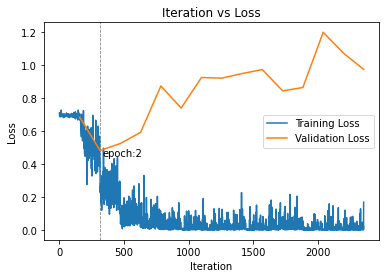

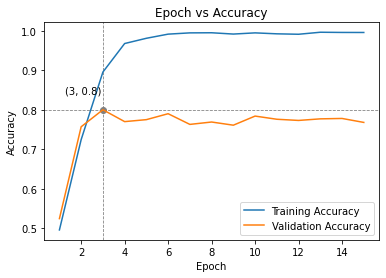

Experiment: DistilBert Adam CrossEntropy LearningRate=0.0001 BatchSize=128 Epoch=15


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_projector.weight', 'vocab_layer_norm.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.bias', 'pre_classifier.weight', 'classi

Epoch 1/15


100%|██████████| 8/8 [00:00<00:00, 15.55it/s, Loss=0.689, Accuracy=0.521, Process=Validation]


Epoch 2/15


100%|██████████| 8/8 [00:00<00:00, 15.51it/s, Loss=0.694, Accuracy=0.504, Process=Validation]


Epoch 3/15


100%|██████████| 8/8 [00:00<00:00, 15.25it/s, Loss=0.506, Accuracy=0.707, Process=Validation]


Epoch 4/15


100%|██████████| 8/8 [00:00<00:00, 14.52it/s, Loss=0.607, Accuracy=0.743, Process=Validation]


Epoch 5/15


100%|██████████| 8/8 [00:00<00:00, 15.43it/s, Loss=0.971, Accuracy=0.730, Process=Validation]


Epoch 6/15


100%|██████████| 8/8 [00:00<00:00, 15.67it/s, Loss=1.202, Accuracy=0.751, Process=Validation]


Epoch 7/15


100%|██████████| 8/8 [00:00<00:00, 15.45it/s, Loss=1.034, Accuracy=0.756, Process=Validation]


Epoch 8/15


100%|██████████| 8/8 [00:00<00:00, 13.93it/s, Loss=1.430, Accuracy=0.727, Process=Validation]


Epoch 9/15


100%|██████████| 8/8 [00:00<00:00, 15.26it/s, Loss=1.113, Accuracy=0.749, Process=Validation]


Epoch 10/15


100%|██████████| 8/8 [00:00<00:00, 16.86it/s, Loss=1.219, Accuracy=0.746, Process=Validation]


Epoch 11/15


100%|██████████| 8/8 [00:00<00:00, 15.49it/s, Loss=1.342, Accuracy=0.739, Process=Validation]


Epoch 12/15


100%|██████████| 8/8 [00:00<00:00, 15.21it/s, Loss=1.466, Accuracy=0.733, Process=Validation]


Epoch 13/15


100%|██████████| 8/8 [00:00<00:00, 15.22it/s, Loss=1.634, Accuracy=0.759, Process=Validation]


Epoch 14/15


100%|██████████| 8/8 [00:00<00:00, 14.29it/s, Loss=1.681, Accuracy=0.754, Process=Validation]


Epoch 15/15


100%|██████████| 8/8 [00:00<00:00, 14.35it/s, Loss=1.527, Accuracy=0.760, Process=Validation]


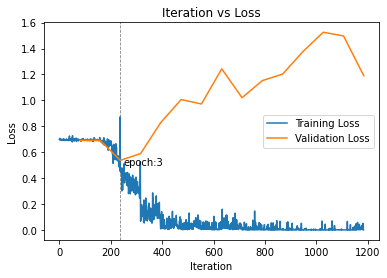

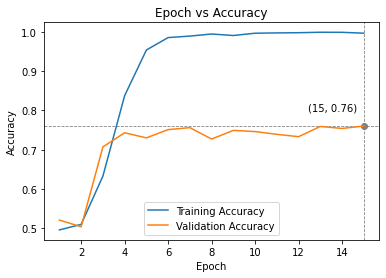

Experiment: DistilBert Adam CrossEntropy LearningRate=1e-05 BatchSize=64 Epoch=15


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_projector.weight', 'vocab_layer_norm.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.bias', 'pre_classifier.weight', 'classi

Epoch 1/15


100%|██████████| 16/16 [00:00<00:00, 30.61it/s, Loss=0.686, Accuracy=0.524, Process=Validation]


Epoch 2/15


100%|██████████| 16/16 [00:00<00:00, 28.81it/s, Loss=0.606, Accuracy=0.696, Process=Validation]


Epoch 3/15


100%|██████████| 16/16 [00:00<00:00, 29.10it/s, Loss=0.594, Accuracy=0.783, Process=Validation]


Epoch 4/15


100%|██████████| 16/16 [00:00<00:00, 28.95it/s, Loss=0.799, Accuracy=0.796, Process=Validation]


Epoch 5/15


100%|██████████| 16/16 [00:00<00:00, 29.15it/s, Loss=0.957, Accuracy=0.804, Process=Validation]


Epoch 6/15


100%|██████████| 16/16 [00:00<00:00, 28.78it/s, Loss=1.244, Accuracy=0.798, Process=Validation]


Epoch 7/15


100%|██████████| 16/16 [00:00<00:00, 29.29it/s, Loss=1.320, Accuracy=0.803, Process=Validation]


Epoch 8/15


100%|██████████| 16/16 [00:00<00:00, 29.05it/s, Loss=1.701, Accuracy=0.795, Process=Validation]


Epoch 9/15


100%|██████████| 16/16 [00:00<00:00, 29.13it/s, Loss=1.795, Accuracy=0.802, Process=Validation]


Epoch 10/15


100%|██████████| 16/16 [00:00<00:00, 28.87it/s, Loss=1.861, Accuracy=0.805, Process=Validation]


Epoch 11/15


100%|██████████| 16/16 [00:00<00:00, 29.32it/s, Loss=1.903, Accuracy=0.803, Process=Validation]


Epoch 12/15


100%|██████████| 16/16 [00:00<00:00, 28.92it/s, Loss=2.016, Accuracy=0.799, Process=Validation]


Epoch 13/15


100%|██████████| 16/16 [00:00<00:00, 29.24it/s, Loss=2.034, Accuracy=0.798, Process=Validation]


Epoch 14/15


100%|██████████| 16/16 [00:00<00:00, 29.03it/s, Loss=2.062, Accuracy=0.801, Process=Validation]


Epoch 15/15


100%|██████████| 16/16 [00:00<00:00, 29.34it/s, Loss=2.103, Accuracy=0.798, Process=Validation]


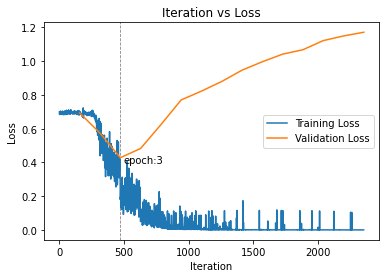

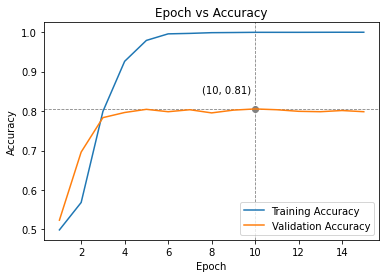

Experiment: DistilBert Adam CrossEntropy LearningRate=1e-05 BatchSize=128 Epoch=15


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_projector.weight', 'vocab_layer_norm.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.bias', 'pre_classifier.weight', 'classi

Epoch 1/15


100%|██████████| 8/8 [00:00<00:00, 15.36it/s, Loss=0.697, Accuracy=0.468, Process=Validation]


Epoch 2/15


100%|██████████| 8/8 [00:00<00:00, 15.41it/s, Loss=0.679, Accuracy=0.540, Process=Validation]


Epoch 3/15


100%|██████████| 8/8 [00:00<00:00, 15.45it/s, Loss=0.523, Accuracy=0.697, Process=Validation]


Epoch 4/15


100%|██████████| 8/8 [00:00<00:00, 15.04it/s, Loss=0.456, Accuracy=0.765, Process=Validation]


Epoch 5/15


100%|██████████| 8/8 [00:00<00:00, 15.02it/s, Loss=0.511, Accuracy=0.776, Process=Validation]


Epoch 6/15


100%|██████████| 8/8 [00:00<00:00, 15.89it/s, Loss=0.592, Accuracy=0.775, Process=Validation]


Epoch 7/15


100%|██████████| 8/8 [00:00<00:00, 15.42it/s, Loss=0.693, Accuracy=0.772, Process=Validation]


Epoch 8/15


100%|██████████| 8/8 [00:00<00:00, 15.60it/s, Loss=0.826, Accuracy=0.768, Process=Validation]


Epoch 9/15


100%|██████████| 8/8 [00:00<00:00, 15.44it/s, Loss=0.900, Accuracy=0.773, Process=Validation]


Epoch 10/15


100%|██████████| 8/8 [00:00<00:00, 15.01it/s, Loss=1.020, Accuracy=0.775, Process=Validation]


Epoch 11/15


100%|██████████| 8/8 [00:00<00:00, 15.42it/s, Loss=1.052, Accuracy=0.779, Process=Validation]


Epoch 12/15


100%|██████████| 8/8 [00:00<00:00, 15.35it/s, Loss=1.154, Accuracy=0.771, Process=Validation]


Epoch 13/15


100%|██████████| 8/8 [00:00<00:00, 15.62it/s, Loss=1.106, Accuracy=0.779, Process=Validation]


Epoch 14/15


100%|██████████| 8/8 [00:00<00:00, 15.40it/s, Loss=1.131, Accuracy=0.780, Process=Validation]


Epoch 15/15


100%|██████████| 8/8 [00:00<00:00, 15.02it/s, Loss=1.162, Accuracy=0.781, Process=Validation]


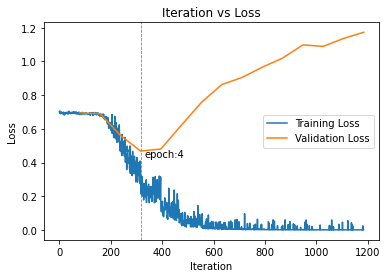

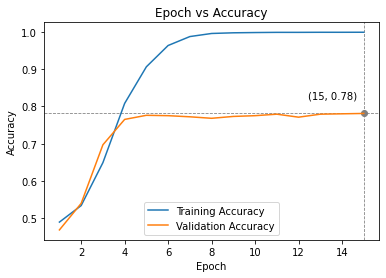

In [17]:
import csv
import os

"""
Experiment Different Hyperparameters with Grid Search method. 
"""

model_name = "DistilBert"

# optimizer_name = 'SGD'
optimizer_name = 'Adam'
# optimizer_name = 'AdaGrad'

loss_name = 'CrossEntropy'
# loss_name = 'Tversky'

# learning_rate_list = [10,1,1e-1,1e-2,1e-3,1e-4,1e-5,1e-6]   # learning rate list
learning_rate_list = [1e-4,1e-5]                              # learning rate list

# batch_size_list = [2,4,8,16,32,64,128,256]                  # batch size list
batch_size_list = [64,128]                                    # batch size list

epoch = 15
    

"""
Do Experiments with Different Hyperparameters
"""
# Create a directory for this experiment.
directory_name = "_".join([time.strftime("%Y%m%d_%H%M", time.localtime()), model_name, optimizer_name, loss_name])
os.mkdir(directory_name)

# Experiment and store the results in a CSV file.
file_name =  "./%s/%s.csv" % (directory_name, directory_name)
with open(file_name, 'a', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(["Model", "Optimizer", "Loss Function", "Learning Rate", "Batch Size", "Test Epoch", 
                     "Validation Loss", "Validation Accuracy", "Highest Accuracy", "Occurred in which Epoch"])
    
    for learning_rate in learning_rate_list:
        
        for batch_size in batch_size_list:
            experiment_info = [model_name, optimizer_name, loss_name, 
                               "LearningRate=%s" % learning_rate, "BatchSize=%s" % batch_size, "Epoch=%s" % epoch]
            print("Experiment:", " ".join(experiment_info))
            
            # Initialize the model
            model = get_model(model_name)
            
            # Get Loss Function and Optimizer
            # loss_function = get_loss_function(loss_name)
            optimizer = get_optimizer(model, optimizer_name, learning_rate)
            
            # Training
            train_loss_list, train_accuracy_list, val_loss_list, val_accuracy_list = train(
                model = model,
                optimizer = optimizer,
                batch_size = batch_size,
                epoch = epoch,
                # loss_function = loss_function
            )
            
            # Plot the result
            save_name = "./%s/%s" % (directory_name, "_".join(experiment_info))
            plot_loss_and_acc(train_loss_list, train_accuracy_list, val_loss_list, val_accuracy_list, save_name)
            
            # Record the validation result 
            writer.writerow([model_name, optimizer_name, loss_name, learning_rate, batch_size, epoch, 
                             val_loss_list, val_accuracy_list, max(val_accuracy_list), np.argmax(val_accuracy_list)+1])
            # torch.cuda.empty_cache()